### Packages

In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotnine as gg
from pathlib import Path
import umap.umap_ as umap
from scipy import stats
from functools import reduce
from sklearn.preprocessing import StandardScaler
import csv


In [44]:
cellline = "A549"

target = 'SECRET'

In [45]:
path = Path(os.path.join('../Figures', 'Features_map', str(target),'Featuregrid', 'All_Features'))
os.makedirs(path)
def makedirectory(path):
    if not os.path.exists(path):
        try:
            os.mkdir(path)    
            
        except OSError as error:
            print("directory already existed")
            
            
    return print("Directory created")
    
            
makedirectory(path)
    
    


FileExistsError: [Errno 17] File exists: '../Figures/Features_map/SECRET/Featuregrid/All_Features'

## Loading data and wrangling

### Loading data

In [1]:

plates = ['BR00100032', 'BR00100037']


def csvpath():
    
    filepath = []
    
    for p in plates:
        path = os.path.join(Path('../', p))
    
        for f in os.listdir(path):
        
            if p + '.csv' in f:
                
                fpath = os.path.join(Path('../', p, f))
            
                filepath.append(fpath)
    
    return  filepath
    
def metadata_path():
    
    metapath = []
    
    for p in plates:
        path = os.path.join(Path('../', p))
    
        for f in os.listdir(path):
        
            if p + '_Metadata.csv' in f:
                
                fpath = os.path.join(Path('../', p, f))
            
                metapath.append(fpath)
    
    return  metapath  
 


csvpath = csvpath()[0]
metapath = metadata_path()[0]

df = pd.read_csv(csvpath)
meta_df = pd.read_csv(metapath)


df.head()

NameError: name 'os' is not defined

### Data Preprocessing 

In [48]:

""" Removing Brightfield and some location features"""

brightfield_features = df.columns[df.columns.str.contains("Brightfield|Children|Center_X|Center_Y|_Number_Object_Number|Parent|Location")]


variables_left = sorted(list(set(df.columns) - set(brightfield_features)))



""" Saving a list in txt format"""

# f = open("featureslist.txt", "w")

# f.writelines(v + '\v' for v in variables_left)


data = df.loc[:, variables_left]




## Merging metadata columns

data = meta_df.merge(data, how='inner', on=['Metadata_Plate', 'Metadata_Well'])

variables = [col for col in data.columns if not "Metadata" in col]
meta = [col for col in data.columns if  "Metadata" in col]

dmso_wells =["M03","A14","M19","G02", "O05","O20","P23", "J14" ,"D18", "D19","P08","M21",
                "P15","I01","B02","A07","L11", "P11","P06","N11","K15","D06","D09","B19","E14",
                "G01", "D04","I14","B08","O10","F10","P09","P07","L10","D02","A23", "J23","M12","C05","H23",
                "O19","O12","N24","K24","N17","B10","N21","C21","C24","O22","C15","I12","N10",
                "E01","P12","P17","B14","A21","N07","B17","L23","P16","C12","A16","F24",
                "D22","A06","M24","D14","N04","B15","K10","P21","C02","O03","A04","A13",
                "O01","H01","O04","C04","A22","D17","K11","B01","B11","L02","F13","B06","I11",
                "N01","G12","F11","K02","C16","I13","C19","J12","G13","D07","D13","K23",
                "H24","C03","O14","E24","E02","M10","M18","A17","B22","C06"]



dmso = data[data['Metadata_Well'].isin(dmso_wells)][variables].values




# ## Z normalization of the features

scaler = StandardScaler()

data_std = scaler.fit(dmso).transform(data[variables].values)


data_std = meta_df.merge(pd.DataFrame(data_std, columns=variables),
                         how='left',
                         left_index=True, 
                         right_index=True)



data_std['Metadata_compound_name'].replace('NA', 'DMSO', inplace=True)
data_std['Metadata_Target'].replace([np.nan, 'CDK14 / pan-TAIRE'], ['NA', 'CDK14_pan-TAIRE'], inplace=True)

data_std['Metadata_compound_name'].replace('NA', 'DMSO', inplace=True)



data_std.loc[data_std['Metadata_compound_name'] == 'DMSO', 'Metadata_Target'] = 'DMSO'



cellline = "A549"

target = 'SECRET'
controls = "DMSO"

target_list =[controls, target]


d = data_std.query('Metadata_cell_line in @ cellline and Metadata_Target in @ target_list')
drug_samples = (d.Metadata_compound_name.unique()
                .tolist()
               )

drug_samples

#[PIN1, CDK14_pan-TAIRE,DCLK1, SECRET]
#d.groupby(['Metadata_compound_name', 'Metadata_Annotation']).mean()


['DMSO', 'BSJ-04-030', 'BSJ-03-136']

## Assigning Features groups, channels and calculating mean z-scores

In [55]:

def All_feature_grid(df, cellline, target_list,comparison):
    
    
     ## Selecting dataframe for specific cellline and samples
        
    d = df.query('Metadata_cell_line in @ cellline and Metadata_Target in @ target_list')
    
    drug_samples = (d.Metadata_compound_name.unique()
                .tolist()
               )


    feat = [col for col in d.columns if not "Metadata" in col]

    featlist =  ['Metadata_compound_name'] + feat



    dn = (d.loc[:, featlist].groupby('Metadata_compound_name')
      .mean()
      .T
      .reset_index()
      .rename(columns={'index': "variables"})
     )


    dn['Compartment'] = np.where(dn.variables.str.contains("Cells"), 'Cells',
                np.where(dn.variables.str.contains("Nuclei"), 'Nuclei', 
                np.where(dn.variables.str.contains("Cytoplasm"), 'Cytoplasm', 'NA')))


    dn['Features'] = np.where(dn.variables.str.contains("RadialDistribution"), 'RadialDistribution', 
                np.where(dn.variables.str.contains("Texture"), 'Texture', 
                np.where(dn.variables.str.contains("Intensity"), 'Intensity',
                np.where(dn.variables.str.contains("AreaShape"), 'AreaShape',
                np.where(dn.variables.str.contains("Correlation"), 'Correlation',
                np.where(dn.variables.str.contains("Neighbors"), 'Neighbors',
                np.where(dn.variables.str.contains("Granularity"), 'Granularity', 'NA')))))))
    
    # Taking mean absolute  z scores
    
    # Incase of FAK
    
    
    if target == "FAK":
        dn = dn.assign(FAK_DMSO = lambda x: abs(x[drug_samples[1]]) - abs(x['DMSO']))
        
        
    elif target == "SECRET":
        dn = dn.assign(Active_DMSO = lambda x: abs(x[drug_samples[2]]) - abs(x['DMSO']),
                  Inactive_DMSO = lambda x: abs(x[drug_samples[1]]) - abs(x['DMSO']),
                  Active_Inactive = lambda x: abs(x[drug_samples[2]]) - abs(x[drug_samples[1]]))
        
    elif target == "PIN1":
        dn = dn.assign(Active_DMSO = lambda x: abs(x[drug_samples[2]]) - abs(x['DMSO']),
                  Inactive_DMSO = lambda x: abs(x[drug_samples[1]]) - abs(x['DMSO']),
                  Active_Inactive = lambda x: abs(x[drug_samples[2]]) - abs(x[drug_samples[1]]))
        
    elif target == "DCLK1":
        dn = dn.assign(Active_DMSO = lambda x: abs(x[drug_samples[1]]) - abs(x['DMSO']),
                  Inactive_DMSO = lambda x: abs(x[drug_samples[2]]) - abs(x['DMSO']),
                  Active_Inactive = lambda x: abs(x[drug_samples[1]]) - abs(x[drug_samples[2]]))
        
    elif target== "CDK14_pan-TAIRE":
        dn = dn.assign(Covalent_DMSO = lambda x: abs(x[drug_samples[1]]) - abs(x['DMSO']),
                  Reversible_DMSO = lambda x: abs(x[drug_samples[2]]) - abs(x['DMSO']),
                  Covalent_Reversible = lambda x: abs(x[drug_samples[1]]) - abs(x[drug_samples[2]]))
        
    elif target== "ERK5":
        dn = dn.assign(JWG_active_DMSO = lambda x: abs(x[drug_samples[1]]) - abs(x['DMSO']),
                  AX_active_DMSO = lambda x: abs(x[drug_samples[2]]) - abs(x['DMSO']),
                  JWG_Inactive_DMSO = lambda x: abs(x[drug_samples[3]]) - abs(x['DMSO']),
                  JWG_active_AX_active = lambda x: abs(x[drug_samples[1]]) - abs(x[drug_samples[2]]),
                  JWG_active_JWG_Inactive = lambda x: abs(x[drug_samples[1]]) - abs(x[drug_samples[3]]),
                  AX_active_JWG_Inactive = lambda x: abs(x[drug_samples[2]]) - abs(x[drug_samples[3]]))

            
   
    
        channels = ['DNA', 'AGP', 'Mito', 'ER', 'RNA']

        feat_groups = ['RadialDistribution', 'Texture', 'Intensity', 'Correlation', 'Granularity']
    
        area_neigh = ['AreaShape','Neighbors']
    
      

        data = []

        for gp in feat_groups:
   
            tmp = dn.query("Features in @ gp")


            for ch in channels:
        
         
                if isinstance(comparison, str):
                
                    comparison = [comparison]
                
            
                for comp in comparison:
            
            
                    tmp1 = (tmp[tmp.variables.str.contains(ch)]
                   .groupby(['Features'])[comp]
                   .mean()
                   )
        
                    if not tmp1.empty:
              
                        Channel = str(ch)
                        Feature = str(gp)
                
                        tmp2 = pd.DataFrame([Feature, Channel]).T            
                        tmp2.columns = ['Features', 'Channels']
                        tmp2[comp] = tmp1[0]
                        data.append(tmp2)

        data = pd.concat(data)
    
   


    return data


def comparison(target):
    if target == 'FAK':
        complist = ['FAK_DMSO']
        return complist
    elif target == 'SECRET':
        complist = ['Active_DMSO', 'Inactive_DMSO', 'Active_Inactive']
        return complist
    elif target == 'DCLK1':
        complist = ['Active_DMSO', 'Inactive_DMSO', 'Active_Inactive']
        return complist
    elif target == 'PIN1':
        complist = ['Active_DMSO', 'Inactive_DMSO', 'Active_Inactive']
        return complist
    elif target == 'PIN1':
        complist = ['Active_DMSO', 'Inactive_DMSO', 'Active_Inactive']
        return complist
    elif target == 'CDK14_pan-TAIRE':
        complist = ['Covalent_DMSO', 'Reversible_DMSO', 'Covalent_Reversible']
        return complist
    elif target == 'ERK5':
        complist = ['JWG_active_DMSO', 'AX_active_DMSO', 'JWG_Inactive_DMSO', 
                    'JWG_active_AX_active', 'JWG_active_JWG_Inactive', 'AX_active_JWG_Inactive']
        return complist
    else:
        print("Invalid Target")
        
complist = comparison(target)
complist
# prf = pd.DataFrame()
# for i in complist:
#     dt = All_feature_grid(data_std, cellline, target_list, str(i)) 
#     prf = pd.concat([prf, dt],axis=1)

# prf = (prf.loc[:,~prf.columns.duplicated()]
#     .replace('Correlation', 'Colocalization', regex=True)
#           )

# \
dt = All_feature_grid(data_std, cellline, target_list, 'Active_DMSO') 

dt


# def plotting_heatmap(complist):
    
    
#     prf = pd.DataFrame()
#     for i in complist:
#         dt = All_feature_grid(data_std, cellline, target_list, str(i)) 
#         prf = pd.concat([prf, dt],axis=1)

#     prf = (prf.loc[:,~prf.columns.duplicated()]
#     .replace('Correlation', 'Colocalization', regex=True)
#           )

# # # # ### calculating the min and 95th percentile value for the color scale bar in plotting for comparison


#     min_value= prf[complist].min(axis=0).min()
#     max_value= np.quantile(prf[complist].values, .95)


#     for cmp in complist:

#         dt = prf.pivot('Features', 'Channels')[cmp]
       
#         fig = plt.figure(figsize=(5,5))
    
#         plt.xlabel('Channels', size=15)
#         plt.ylabel('Features', size=15)
#         plt.title(str(cmp) + " {" + str(target) + "}", size=15)
#         ax = sns.heatmap(dt, annot=True, fmt=".3f",annot_kws={"size": 12}, linewidths=1, vmin=min_value, vmax=max_value, linecolor="gray", square=True, cbar_kws={"shrink": .82}, cmap="Blues", cbar=True)
    
#         outdirpath = Path(os.path.join('../Figures', 'Features_map', str(target),'Featuregrid', 'All_Features'))
#         fig.savefig(str(outdirpath) + '/' + str(target) + "_" + str(cmp)+ '_allcompartments.png', bbox_inches="tight")
        
        
        
# # ## Functions Calling

# complist = comparison(target)


# plotting_heatmap(complist)




UnboundLocalError: local variable 'data' referenced before assignment

In [41]:
prf = pd.DataFrame()
for i in complist:
    dt = All_feature_grid(data_std, cellline, target_list, str(i)) 
    prf = pd.concat([prf, dt],axis=1)

prf = (prf.loc[:,~prf.columns.duplicated()]
       .replace('Correlation', 'Colocalization', regex=True)
          )

prf

UnboundLocalError: local variable 'data' referenced before assignment

## Neighobors feature

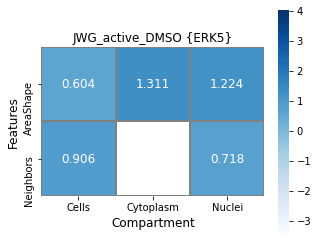

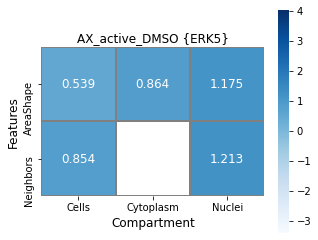

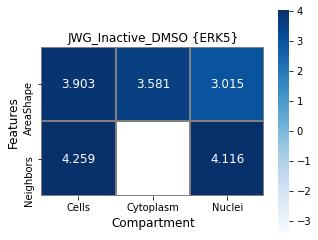

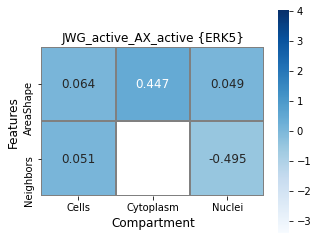

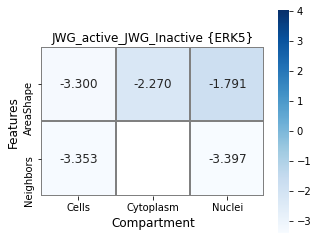

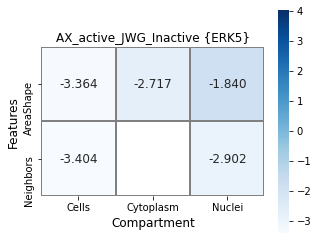

In [193]:

def Areashape_Neighbors_feature_grid(df, cellline, target_list, target):
    d = df.query('Metadata_cell_line in @ cellline and Metadata_Target in @ target_list')
    drug_samples = (d.Metadata_compound_name.unique()
                    .tolist()
                   )


    feat = [col for col in d.columns if not "Metadata" in col]

    featlist =  ['Metadata_compound_name'] + feat
    


    dn = (d.loc[:, featlist].groupby('Metadata_compound_name')
        .mean()
        .T
        .reset_index()
        .rename(columns={'index': "variables"})
        )


    dn['Compartment'] = np.where(dn.variables.str.contains("Cells"), 'Cells',
                                 np.where(dn.variables.str.contains("Nuclei"), 'Nuclei', 
                                 np.where(dn.variables.str.contains("Cytoplasm"), 'Cytoplasm', 'NA')))

    dn['Features'] = np.where(dn.variables.str.contains("AreaShape"), 'AreaShape',
                              np.where(dn.variables.str.contains("Neighbors"), 'Neighbors', 'NA'))


    dn = dn.query("Features != 'NA'")
    
#Taking mean absolute  z scores

    if target == "FAK":
        
        dn = dn.assign(FAK_DMSO = lambda x: abs(x[drug_samples[1]]) - abs(x['DMSO']))
        
        
    elif target == "SECRET":
        dn = dn.assign(Active_DMSO = lambda x: abs(x[drug_samples[2]]) - abs(x['DMSO']),
                  Inactive_DMSO = lambda x: abs(x[drug_samples[1]]) - abs(x['DMSO']),
                  Active_Inactive = lambda x: abs(x[drug_samples[2]]) - abs(x[drug_samples[1]]))
        
    elif target == "PIN1":
        dn = dn.assign(Active_DMSO = lambda x: abs(x[drug_samples[2]]) - abs(x['DMSO']),
                  Inactive_DMSO = lambda x: abs(x[drug_samples[1]]) - abs(x['DMSO']),
                  Active_Inactive = lambda x: abs(x[drug_samples[2]]) - abs(x[drug_samples[1]]))
        
    elif target == "DCLK1":
        dn = dn.assign(Active_DMSO = lambda x: abs(x[drug_samples[1]]) - abs(x['DMSO']),
                  Inactive_DMSO = lambda x: abs(x[drug_samples[2]]) - abs(x['DMSO']),
                  Active_Inactive = lambda x: abs(x[drug_samples[1]]) - abs(x[drug_samples[2]]))
        
    elif target== "CDK14_pan-TAIRE":
        dn = dn.assign(Covalent_DMSO = lambda x: abs(x[drug_samples[1]]) - abs(x['DMSO']),
                  Reversible_DMSO = lambda x: abs(x[drug_samples[2]]) - abs(x['DMSO']),
                  Covalent_Reversible = lambda x: abs(x[drug_samples[1]]) - abs(x[drug_samples[2]]))
        
    elif target== "ERK5":
        dn = dn.assign(JWG_active_DMSO = lambda x: abs(x[drug_samples[1]]) - abs(x['DMSO']),
                  AX_active_DMSO = lambda x: abs(x[drug_samples[2]]) - abs(x['DMSO']),
                  JWG_Inactive_DMSO = lambda x: abs(x[drug_samples[3]]) - abs(x['DMSO']),
                  JWG_active_AX_active = lambda x: abs(x[drug_samples[1]]) - abs(x[drug_samples[2]]),
                  JWG_active_JWG_Inactive = lambda x: abs(x[drug_samples[1]]) - abs(x[drug_samples[3]]),
                  AX_active_JWG_Inactive = lambda x: abs(x[drug_samples[2]]) - abs(x[drug_samples[3]]))
        
        
    def comparison(target):
        
        
        if target == 'FAK':
            complist = ['FAK_DMSO']
            return complist
        elif target == 'SECRET':
            complist = ['Active_DMSO', 'Inactive_DMSO', 'Active_Inactive']
            return complist
        elif target == 'DCLK1':
            complist = ['Active_DMSO', 'Inactive_DMSO', 'Active_Inactive']
            return complist
        elif target == 'PIN1':
            complist = ['Active_DMSO', 'Inactive_DMSO', 'Active_Inactive']
            return complist
        elif target == 'PIN1':
            complist = ['Active_DMSO', 'Inactive_DMSO', 'Active_Inactive']
            return complist
        elif target == 'CDK14_pan-TAIRE':
            complist = ['Covalent_DMSO', 'Reversible_DMSO', 'Covalent_Reversible']
            return complist
        elif target == 'ERK5':
            complist = ['JWG_active_DMSO', 'AX_active_DMSO', 'JWG_Inactive_DMSO', 
                    'JWG_active_AX_active', 'JWG_active_JWG_Inactive', 'AX_active_JWG_Inactive']
            return complist
        else:
            print("Invalid Target")

    complist=comparison(target)
    
    data = []
    
    
    for comp in complist:
    
        tmp2 = (dn.groupby(['Features', 'Compartment'])[comp]
        .mean()
        .reset_index()
           )
    
        data.append(tmp2)
            
            
            
    prf = pd.concat(data, axis=1)
      


    prf = prf.loc[:, ~prf.columns.duplicated()]
    
    ### calculating the min and 95th percentile value for the color scale bar in plotting for comparison
    
    min_value= prf[complist].min(axis=0).min()
    max_value= np.quantile(prf[complist].values, .95)
    
    for cmp in complist:
        
    
        tmp3 = prf.pivot('Features', 'Compartment')[cmp]

    ### Plotting
      
        plt.figure(figsize=(5,5))
        plt.xlabel('Compartment', size=12)
        plt.ylabel('Features', size=12)
        plt.title(str(cmp) + " {" + str(target) + "}", size=12)
        ax = sns.heatmap(tmp3, annot=True, fmt=".3f",annot_kws={"size": 12}, vmin = min_value, vmax = max_value,linewidths=1, linecolor="gray", square=True, cbar_kws={"shrink": .82}, cmap="Blues", cbar=True)
    
        fig = ax.get_figure()
        outdirpath = Path(os.path.join('../Figures', 'Features_map', str(target),'Featuregrid', 'All_Features'))
    
        fig.savefig(str(outdirpath) + '/' + str(target) + "_" + str(cmp)+ '_areashape_neighbors.png', bbox_inches="tight")
    
    
    return fig

prf = Areashape_Neighbors_feature_grid(data_std, cellline, target_list, target)

   









     

